In [1]:
import glob, os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
import sklearn
print(sklearn.__version__)
from sklearn.cross_validation import train_test_split  
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score

0.19.1


/home/xnguyen/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/xnguyen/.local/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Exploring data sets

In [2]:
# read list of vehicles file
cars = []
for directory in glob.glob("data/vehicles/*"):
    cars.extend(glob.glob(directory+"/*"))
len(cars)

8792

In [3]:
notcars = []
for directory in glob.glob("data/non-vehicles/*"):
    notcars.extend(glob.glob(directory+"/*"))
len(notcars)

8968

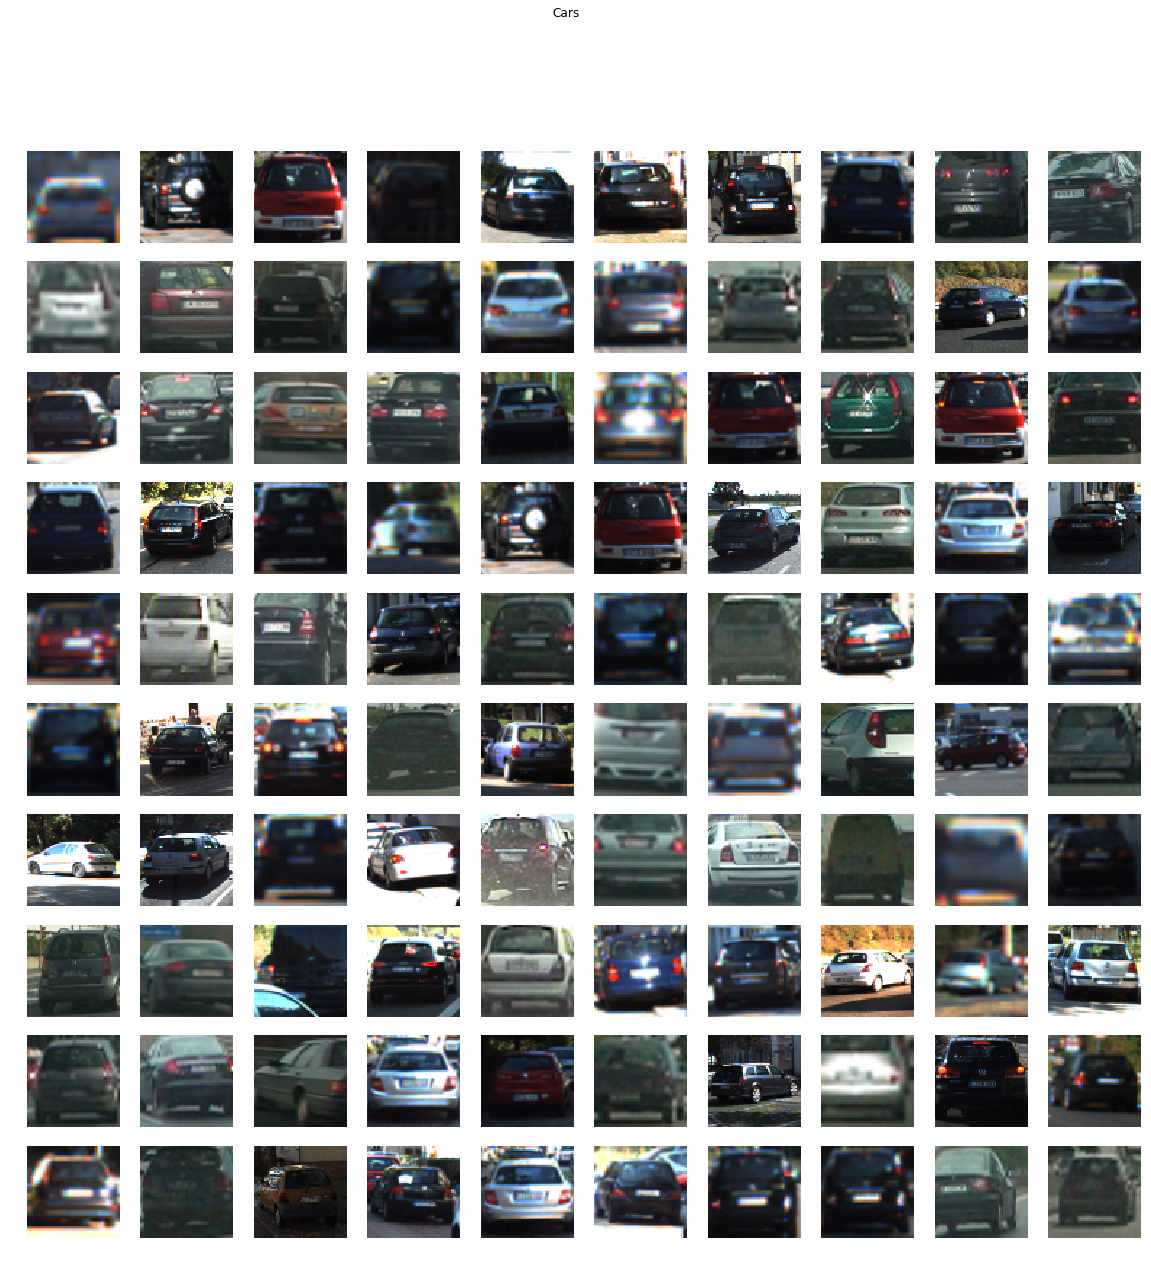

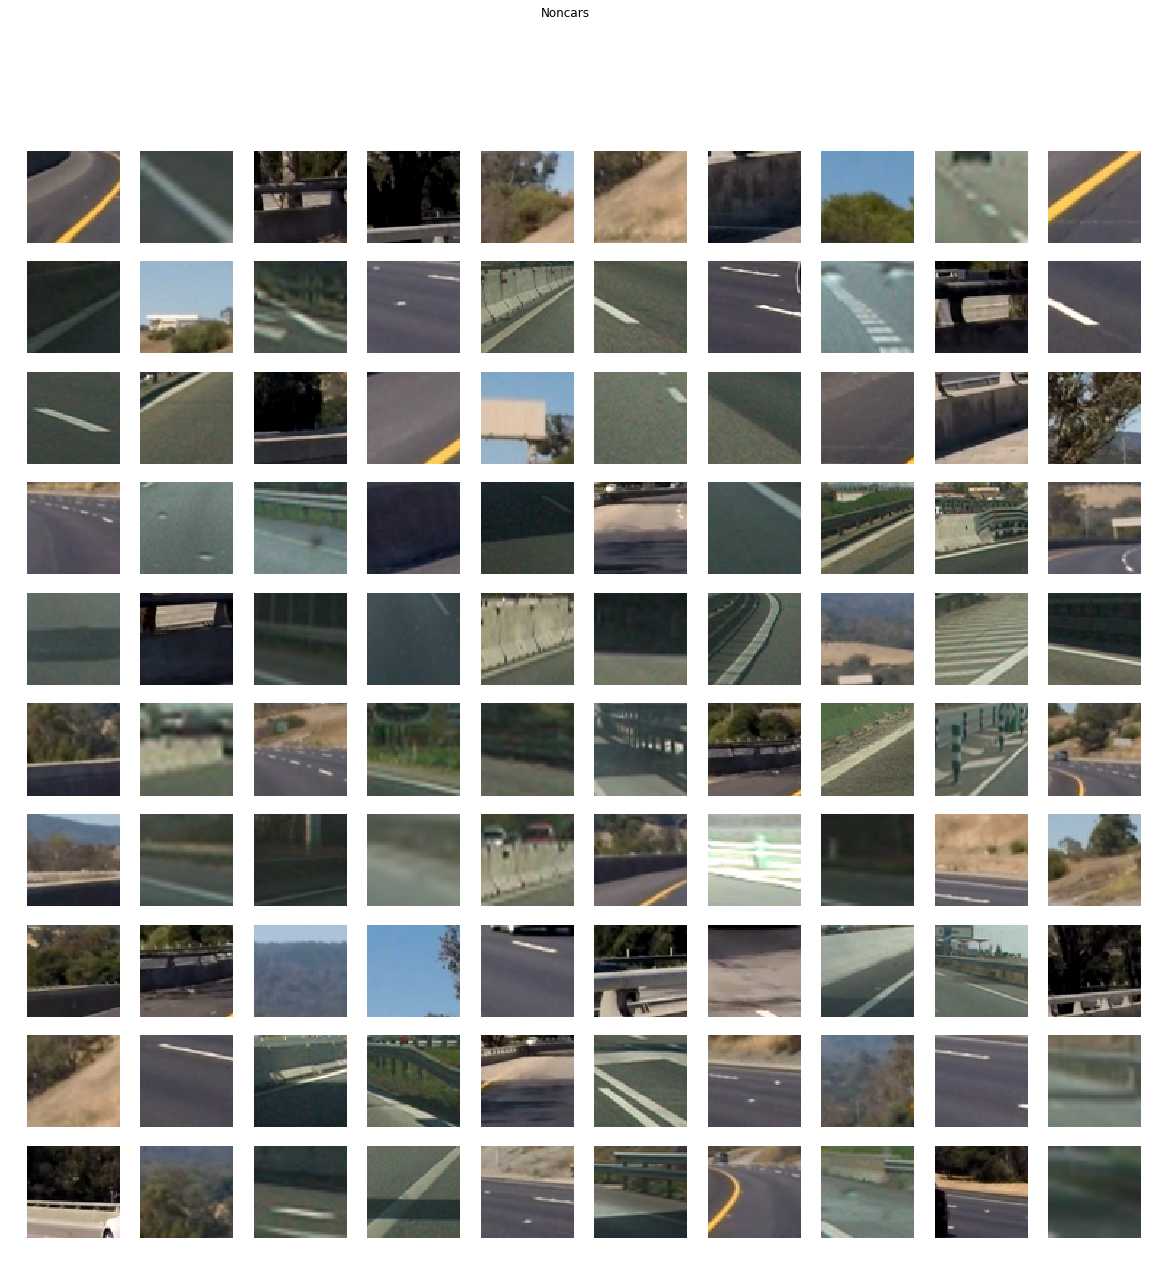

In [4]:
from random import shuffle

shuffle(cars)
shuffle(notcars)

plt.figure(figsize=(20,20))    
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(mpimg.imread(cars[i]))
    plt.axis('off')
plt.suptitle('Cars')
plt.savefig('examples/cars_examples.png')

plt.figure(figsize=(20,20))    
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(mpimg.imread(notcars[i]))
    plt.axis('off')
plt.suptitle('Noncars')    
plt.savefig('examples/noncars_examples.png')
plt.show()


# Extracting various features

In [6]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


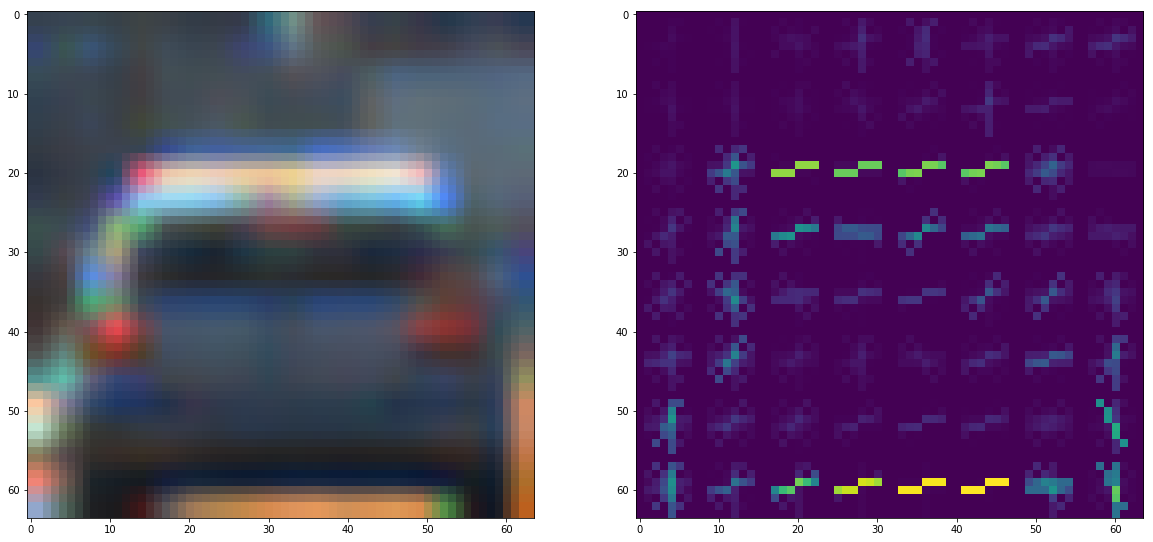

In [7]:
# test HOG visualization
img = mpimg.imread(cars[0])
orient = 9
pix_per_cell = 8
cell_per_block = 2
features, hog_image = get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

plt.figure(figsize=(20,20));
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(hog_image)

In [17]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_color_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    

In [28]:
### TODO: Tweak these parameters and see how the results change.
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True)
notcar_features = extract_features(notcars, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

95.14 Seconds to extract HOG features...


24324.19678321764
12822.787672559043


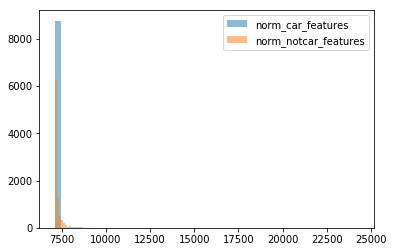

In [30]:
norm_car_features = [np.linalg.norm(x) for x in car_features ]
norm_notcar_features = [np.linalg.norm(x) for x in notcar_features ]

print(np.max(norm_car_features))
print(np.max(norm_notcar_features))

plt.hist(norm_car_features, 50,  alpha=0.5, label='norm_car_features')
plt.hist(norm_notcar_features, 50,  alpha=0.5, label='norm_notcar_features')
plt.legend(loc='upper right')
plt.show()

In [31]:
print(np.mean(norm_car_features))
print(np.mean(norm_notcar_features))

7110.794398452868
7224.282079349499


In [32]:
import pickle
with open('all_features.pickle', 'wb') as handle:
    pickle.dump({'car_features':car_features, 'notcar_features':notcar_features}, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Training classifiers

In [33]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler(copy=True, with_mean=True, with_std=True).fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


In [34]:
X_train.shape

(14208, 8460)

## Linear SVM

In [35]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

36.8 Seconds to train SVC...
Test Accuracy of SVC =  0.9626
My SVC predicts:  [1. 1. 0. 0. 1. 0. 1. 1. 1. 1.]
For these 10 labels:  [1. 1. 0. 0. 1. 0. 1. 1. 1. 1.]
0.00179 Seconds to predict 10 labels with SVC


## Xgboost

In [36]:
import xgboost as xgb
# read in data
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


In [37]:
model = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=150,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.75,
 objective= 'binary:logistic',
 nthread=16,
 scale_pos_weight=1)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True, )


[0]	validation_0-error:0.088049	validation_0-logloss:0.626398	validation_1-error:0.110642	validation_1-logloss:0.630088
[1]	validation_0-error:0.073691	validation_0-logloss:0.569039	validation_1-error:0.100225	validation_1-logloss:0.576248
[2]	validation_0-error:0.059755	validation_0-logloss:0.520849	validation_1-error:0.083052	validation_1-logloss:0.532212
[3]	validation_0-error:0.057362	validation_0-logloss:0.478095	validation_1-error:0.07911	validation_1-logloss:0.492144
[4]	validation_0-error:0.051872	validation_0-logloss:0.440591	validation_1-error:0.075732	validation_1-logloss:0.456986
[5]	validation_0-error:0.045608	validation_0-logloss:0.407828	validation_1-error:0.066723	validation_1-logloss:0.426005
[6]	validation_0-error:0.042511	validation_0-logloss:0.378611	validation_1-error:0.065597	validation_1-logloss:0.397993
[7]	validation_0-error:0.038007	validation_0-logloss:0.353322	validation_1-error:0.063063	validation_1-logloss:0.374633
[8]	validation_0-error:0.035895	validatio

[69]	validation_0-error:0.000845	validation_0-logloss:0.026298	validation_1-error:0.015484	validation_1-logloss:0.061513
[70]	validation_0-error:0.000845	validation_0-logloss:0.025492	validation_1-error:0.014921	validation_1-logloss:0.060456
[71]	validation_0-error:0.000704	validation_0-logloss:0.024711	validation_1-error:0.01464	validation_1-logloss:0.059494
[72]	validation_0-error:0.000704	validation_0-logloss:0.023876	validation_1-error:0.014921	validation_1-logloss:0.058568
[73]	validation_0-error:0.000704	validation_0-logloss:0.023116	validation_1-error:0.015203	validation_1-logloss:0.057745
[74]	validation_0-error:0.000563	validation_0-logloss:0.022368	validation_1-error:0.014077	validation_1-logloss:0.056888
[75]	validation_0-error:0.000563	validation_0-logloss:0.021576	validation_1-error:0.014358	validation_1-logloss:0.055736
[76]	validation_0-error:0.000563	validation_0-logloss:0.020859	validation_1-error:0.013514	validation_1-logloss:0.05477
[77]	validation_0-error:0.000563	v

[139]	validation_0-error:0	validation_0-logloss:0.004377	validation_1-error:0.010417	validation_1-logloss:0.032086
[140]	validation_0-error:0	validation_0-logloss:0.004285	validation_1-error:0.010135	validation_1-logloss:0.031893
[141]	validation_0-error:0	validation_0-logloss:0.004199	validation_1-error:0.010417	validation_1-logloss:0.031821
[142]	validation_0-error:0	validation_0-logloss:0.004107	validation_1-error:0.010135	validation_1-logloss:0.031728
[143]	validation_0-error:0	validation_0-logloss:0.004028	validation_1-error:0.009854	validation_1-logloss:0.031598
[144]	validation_0-error:0	validation_0-logloss:0.003947	validation_1-error:0.009854	validation_1-logloss:0.031535
[145]	validation_0-error:0	validation_0-logloss:0.003866	validation_1-error:0.009854	validation_1-logloss:0.031491
[146]	validation_0-error:0	validation_0-logloss:0.003792	validation_1-error:0.009854	validation_1-logloss:0.031347
[147]	validation_0-error:0	validation_0-logloss:0.003724	validation_1-error:0.00

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.75, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=1, nthread=8, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [49]:
# make predictions for test data
y_pred = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 98.99%


/home/xnguyen/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [39]:
# save model to file
pickle.dump((model, X_scaler), open("xgboost_allfeatures_small.pkl", "wb"))

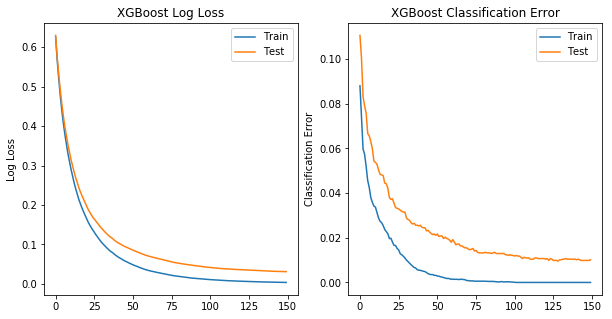

In [40]:
# retrieve performance metrics
def plot_model_learning_curve(model):
    results = model.evals_result()
    epochs = len(results['validation_0']['error'])
    x_axis = range(0, epochs)
    # plot log loss
    plt.figure(figsize=(10,5))
    
    ax = plt.subplot(1,2,1)
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
    ax.legend()
    plt.ylabel('Log Loss')
    plt.title('XGBoost Log Loss')

    # plot classification error
    ax = plt.subplot(1,2,2)
    ax.plot(x_axis, results['validation_0']['error'], label='Train')
    ax.plot(x_axis, results['validation_1']['error'], label='Test')
    ax.legend()
    plt.ylabel('Classification Error')
    plt.title('XGBoost Classification Error')
    plt.show()
plot_model_learning_curve(model)

In [43]:
model2 = xgb.XGBClassifier(
 learning_rate = 0.05,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=1,
 gamma=0,
 subsample=0.5,
 colsample_bytree=0.5,
 objective= 'binary:logistic',
 nthread=16,
 scale_pos_weight=1)
eval_set = [(X_train, y_train), (X_test, y_test)]
model2.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True, )


[0]	validation_0-error:0.116624	validation_0-logloss:0.662525	validation_1-error:0.13795	validation_1-logloss:0.664161
[1]	validation_0-error:0.107193	validation_0-logloss:0.634381	validation_1-error:0.120777	validation_1-logloss:0.636924
[2]	validation_0-error:0.092765	validation_0-logloss:0.608503	validation_1-error:0.107827	validation_1-logloss:0.612293
[3]	validation_0-error:0.090724	validation_0-logloss:0.584451	validation_1-error:0.107264	validation_1-logloss:0.589271
[4]	validation_0-error:0.079744	validation_0-logloss:0.56206	validation_1-error:0.094595	validation_1-logloss:0.567687
[5]	validation_0-error:0.074606	validation_0-logloss:0.540646	validation_1-error:0.091216	validation_1-logloss:0.547474
[6]	validation_0-error:0.072987	validation_0-logloss:0.52119	validation_1-error:0.09009	validation_1-logloss:0.528738
[7]	validation_0-error:0.070242	validation_0-logloss:0.502283	validation_1-error:0.090653	validation_1-logloss:0.510526
[8]	validation_0-error:0.069609	validation_0

[69]	validation_0-error:0.016399	validation_0-logloss:0.123254	validation_1-error:0.036881	validation_1-logloss:0.152911
[70]	validation_0-error:0.016329	validation_0-logloss:0.121238	validation_1-error:0.036599	validation_1-logloss:0.151061
[71]	validation_0-error:0.016118	validation_0-logloss:0.119186	validation_1-error:0.035473	validation_1-logloss:0.149147
[72]	validation_0-error:0.015414	validation_0-logloss:0.117301	validation_1-error:0.036036	validation_1-logloss:0.147491
[73]	validation_0-error:0.015343	validation_0-logloss:0.115611	validation_1-error:0.035473	validation_1-logloss:0.145756
[74]	validation_0-error:0.015132	validation_0-logloss:0.113844	validation_1-error:0.034628	validation_1-logloss:0.144169
[75]	validation_0-error:0.014569	validation_0-logloss:0.111683	validation_1-error:0.035473	validation_1-logloss:0.142109
[76]	validation_0-error:0.014288	validation_0-logloss:0.109873	validation_1-error:0.035473	validation_1-logloss:0.140173
[77]	validation_0-error:0.014077

[137]	validation_0-error:0.004786	validation_0-logloss:0.050042	validation_1-error:0.020833	validation_1-logloss:0.080019
[138]	validation_0-error:0.004716	validation_0-logloss:0.049462	validation_1-error:0.020552	validation_1-logloss:0.079418
[139]	validation_0-error:0.004786	validation_0-logloss:0.048846	validation_1-error:0.02027	validation_1-logloss:0.078789
[140]	validation_0-error:0.004645	validation_0-logloss:0.048336	validation_1-error:0.019989	validation_1-logloss:0.078237
[141]	validation_0-error:0.004505	validation_0-logloss:0.047753	validation_1-error:0.019989	validation_1-logloss:0.077689
[142]	validation_0-error:0.004434	validation_0-logloss:0.047274	validation_1-error:0.019426	validation_1-logloss:0.077147
[143]	validation_0-error:0.004364	validation_0-logloss:0.046656	validation_1-error:0.019707	validation_1-logloss:0.076542
[144]	validation_0-error:0.004364	validation_0-logloss:0.046043	validation_1-error:0.018863	validation_1-logloss:0.075759
[145]	validation_0-error:

[205]	validation_0-error:0.001619	validation_0-logloss:0.024378	validation_1-error:0.013795	validation_1-logloss:0.052066
[206]	validation_0-error:0.001548	validation_0-logloss:0.024197	validation_1-error:0.013795	validation_1-logloss:0.051819
[207]	validation_0-error:0.001548	validation_0-logloss:0.023966	validation_1-error:0.013514	validation_1-logloss:0.051588
[208]	validation_0-error:0.001548	validation_0-logloss:0.023728	validation_1-error:0.013232	validation_1-logloss:0.05137
[209]	validation_0-error:0.001478	validation_0-logloss:0.02354	validation_1-error:0.013514	validation_1-logloss:0.051247
[210]	validation_0-error:0.001478	validation_0-logloss:0.023244	validation_1-error:0.013795	validation_1-logloss:0.050875
[211]	validation_0-error:0.001197	validation_0-logloss:0.022969	validation_1-error:0.013514	validation_1-logloss:0.050681
[212]	validation_0-error:0.001267	validation_0-logloss:0.022766	validation_1-error:0.014358	validation_1-logloss:0.050494
[213]	validation_0-error:0

[273]	validation_0-error:0.000422	validation_0-logloss:0.012876	validation_1-error:0.011261	validation_1-logloss:0.038709
[274]	validation_0-error:0.000352	validation_0-logloss:0.012767	validation_1-error:0.011261	validation_1-logloss:0.038577
[275]	validation_0-error:0.000352	validation_0-logloss:0.012647	validation_1-error:0.011261	validation_1-logloss:0.038434
[276]	validation_0-error:0.000282	validation_0-logloss:0.012563	validation_1-error:0.011261	validation_1-logloss:0.038375
[277]	validation_0-error:0.000282	validation_0-logloss:0.012465	validation_1-error:0.011261	validation_1-logloss:0.038238
[278]	validation_0-error:0.000282	validation_0-logloss:0.012366	validation_1-error:0.01098	validation_1-logloss:0.038089
[279]	validation_0-error:0.000282	validation_0-logloss:0.012258	validation_1-error:0.011261	validation_1-logloss:0.037941
[280]	validation_0-error:0.000282	validation_0-logloss:0.01218	validation_1-error:0.011261	validation_1-logloss:0.037978
[281]	validation_0-error:0

[343]	validation_0-error:0	validation_0-logloss:0.00732	validation_1-error:0.009572	validation_1-logloss:0.03227
[344]	validation_0-error:0	validation_0-logloss:0.007252	validation_1-error:0.009854	validation_1-logloss:0.032158
[345]	validation_0-error:0	validation_0-logloss:0.007197	validation_1-error:0.009572	validation_1-logloss:0.032105
[346]	validation_0-error:0	validation_0-logloss:0.007146	validation_1-error:0.009572	validation_1-logloss:0.032061
[347]	validation_0-error:0	validation_0-logloss:0.007088	validation_1-error:0.009572	validation_1-logloss:0.032003
[348]	validation_0-error:0	validation_0-logloss:0.007027	validation_1-error:0.009572	validation_1-logloss:0.031948
[349]	validation_0-error:0	validation_0-logloss:0.006992	validation_1-error:0.009854	validation_1-logloss:0.031885
[350]	validation_0-error:0	validation_0-logloss:0.006931	validation_1-error:0.009854	validation_1-logloss:0.031895
[351]	validation_0-error:0	validation_0-logloss:0.006873	validation_1-error:0.0092

[415]	validation_0-error:0	validation_0-logloss:0.004424	validation_1-error:0.008727	validation_1-logloss:0.028222
[416]	validation_0-error:0	validation_0-logloss:0.004395	validation_1-error:0.008727	validation_1-logloss:0.02822
[417]	validation_0-error:0	validation_0-logloss:0.00437	validation_1-error:0.008446	validation_1-logloss:0.028206
[418]	validation_0-error:0	validation_0-logloss:0.004341	validation_1-error:0.008727	validation_1-logloss:0.028146
[419]	validation_0-error:0	validation_0-logloss:0.004316	validation_1-error:0.008727	validation_1-logloss:0.028133
[420]	validation_0-error:0	validation_0-logloss:0.004292	validation_1-error:0.008727	validation_1-logloss:0.028114
[421]	validation_0-error:0	validation_0-logloss:0.004265	validation_1-error:0.008727	validation_1-logloss:0.028119
[422]	validation_0-error:0	validation_0-logloss:0.00424	validation_1-error:0.008727	validation_1-logloss:0.028076
[423]	validation_0-error:0	validation_0-logloss:0.004213	validation_1-error:0.00872

[487]	validation_0-error:0	validation_0-logloss:0.002923	validation_1-error:0.008446	validation_1-logloss:0.025809
[488]	validation_0-error:0	validation_0-logloss:0.002908	validation_1-error:0.008446	validation_1-logloss:0.025794
[489]	validation_0-error:0	validation_0-logloss:0.002891	validation_1-error:0.008446	validation_1-logloss:0.025766
[490]	validation_0-error:0	validation_0-logloss:0.002878	validation_1-error:0.008446	validation_1-logloss:0.025753
[491]	validation_0-error:0	validation_0-logloss:0.002857	validation_1-error:0.008446	validation_1-logloss:0.025717
[492]	validation_0-error:0	validation_0-logloss:0.002844	validation_1-error:0.008446	validation_1-logloss:0.025651
[493]	validation_0-error:0	validation_0-logloss:0.002829	validation_1-error:0.008446	validation_1-logloss:0.025602
[494]	validation_0-error:0	validation_0-logloss:0.002813	validation_1-error:0.008446	validation_1-logloss:0.025561
[495]	validation_0-error:0	validation_0-logloss:0.002803	validation_1-error:0.00

[559]	validation_0-error:0	validation_0-logloss:0.002089	validation_1-error:0.008446	validation_1-logloss:0.024182
[560]	validation_0-error:0	validation_0-logloss:0.002078	validation_1-error:0.008446	validation_1-logloss:0.024159
[561]	validation_0-error:0	validation_0-logloss:0.00207	validation_1-error:0.008164	validation_1-logloss:0.024128
[562]	validation_0-error:0	validation_0-logloss:0.002064	validation_1-error:0.008164	validation_1-logloss:0.024117
[563]	validation_0-error:0	validation_0-logloss:0.002057	validation_1-error:0.008164	validation_1-logloss:0.024103
[564]	validation_0-error:0	validation_0-logloss:0.002048	validation_1-error:0.007883	validation_1-logloss:0.024111
[565]	validation_0-error:0	validation_0-logloss:0.002039	validation_1-error:0.008164	validation_1-logloss:0.024102
[566]	validation_0-error:0	validation_0-logloss:0.00203	validation_1-error:0.008164	validation_1-logloss:0.02407
[567]	validation_0-error:0	validation_0-logloss:0.002022	validation_1-error:0.00816

[631]	validation_0-error:0	validation_0-logloss:0.001608	validation_1-error:0.008164	validation_1-logloss:0.023347
[632]	validation_0-error:0	validation_0-logloss:0.001602	validation_1-error:0.008164	validation_1-logloss:0.023353
[633]	validation_0-error:0	validation_0-logloss:0.001598	validation_1-error:0.008164	validation_1-logloss:0.023381
[634]	validation_0-error:0	validation_0-logloss:0.001592	validation_1-error:0.008164	validation_1-logloss:0.023398
[635]	validation_0-error:0	validation_0-logloss:0.001587	validation_1-error:0.008164	validation_1-logloss:0.023381
[636]	validation_0-error:0	validation_0-logloss:0.001582	validation_1-error:0.008164	validation_1-logloss:0.023343
[637]	validation_0-error:0	validation_0-logloss:0.001577	validation_1-error:0.008164	validation_1-logloss:0.023334
[638]	validation_0-error:0	validation_0-logloss:0.001571	validation_1-error:0.008164	validation_1-logloss:0.023316
[639]	validation_0-error:0	validation_0-logloss:0.001566	validation_1-error:0.00

[703]	validation_0-error:0	validation_0-logloss:0.001294	validation_1-error:0.008164	validation_1-logloss:0.022801
[704]	validation_0-error:0	validation_0-logloss:0.001291	validation_1-error:0.008164	validation_1-logloss:0.022817
[705]	validation_0-error:0	validation_0-logloss:0.001288	validation_1-error:0.008164	validation_1-logloss:0.0228
[706]	validation_0-error:0	validation_0-logloss:0.001284	validation_1-error:0.008164	validation_1-logloss:0.022811
[707]	validation_0-error:0	validation_0-logloss:0.00128	validation_1-error:0.008164	validation_1-logloss:0.022829
[708]	validation_0-error:0	validation_0-logloss:0.001277	validation_1-error:0.008164	validation_1-logloss:0.02281
[709]	validation_0-error:0	validation_0-logloss:0.001274	validation_1-error:0.008164	validation_1-logloss:0.022827
[710]	validation_0-error:0	validation_0-logloss:0.001271	validation_1-error:0.008164	validation_1-logloss:0.022811
[711]	validation_0-error:0	validation_0-logloss:0.001268	validation_1-error:0.008164

[775]	validation_0-error:0	validation_0-logloss:0.001088	validation_1-error:0.007883	validation_1-logloss:0.022317
[776]	validation_0-error:0	validation_0-logloss:0.001086	validation_1-error:0.007883	validation_1-logloss:0.022317
[777]	validation_0-error:0	validation_0-logloss:0.001083	validation_1-error:0.007883	validation_1-logloss:0.022317
[778]	validation_0-error:0	validation_0-logloss:0.00108	validation_1-error:0.007883	validation_1-logloss:0.0223
[779]	validation_0-error:0	validation_0-logloss:0.001079	validation_1-error:0.007601	validation_1-logloss:0.022298
[780]	validation_0-error:0	validation_0-logloss:0.001076	validation_1-error:0.007601	validation_1-logloss:0.022271
[781]	validation_0-error:0	validation_0-logloss:0.001074	validation_1-error:0.007601	validation_1-logloss:0.022259
[782]	validation_0-error:0	validation_0-logloss:0.001072	validation_1-error:0.007601	validation_1-logloss:0.022291
[783]	validation_0-error:0	validation_0-logloss:0.00107	validation_1-error:0.007601

[847]	validation_0-error:0	validation_0-logloss:0.000946	validation_1-error:0.007601	validation_1-logloss:0.022011
[848]	validation_0-error:0	validation_0-logloss:0.000944	validation_1-error:0.007601	validation_1-logloss:0.021988
[849]	validation_0-error:0	validation_0-logloss:0.000942	validation_1-error:0.007601	validation_1-logloss:0.022007
[850]	validation_0-error:0	validation_0-logloss:0.000941	validation_1-error:0.007601	validation_1-logloss:0.022008
[851]	validation_0-error:0	validation_0-logloss:0.000939	validation_1-error:0.007601	validation_1-logloss:0.02201
[852]	validation_0-error:0	validation_0-logloss:0.000937	validation_1-error:0.007601	validation_1-logloss:0.022027
[853]	validation_0-error:0	validation_0-logloss:0.000936	validation_1-error:0.007601	validation_1-logloss:0.022016
[854]	validation_0-error:0	validation_0-logloss:0.000934	validation_1-error:0.007601	validation_1-logloss:0.022002
[855]	validation_0-error:0	validation_0-logloss:0.000932	validation_1-error:0.007

[919]	validation_0-error:0	validation_0-logloss:0.000842	validation_1-error:0.007883	validation_1-logloss:0.021888
[920]	validation_0-error:0	validation_0-logloss:0.000841	validation_1-error:0.007883	validation_1-logloss:0.021921
[921]	validation_0-error:0	validation_0-logloss:0.000839	validation_1-error:0.007883	validation_1-logloss:0.021917
[922]	validation_0-error:0	validation_0-logloss:0.000838	validation_1-error:0.007883	validation_1-logloss:0.021925
[923]	validation_0-error:0	validation_0-logloss:0.000837	validation_1-error:0.007883	validation_1-logloss:0.021939
[924]	validation_0-error:0	validation_0-logloss:0.000836	validation_1-error:0.007883	validation_1-logloss:0.021923
[925]	validation_0-error:0	validation_0-logloss:0.000835	validation_1-error:0.007883	validation_1-logloss:0.021902
[926]	validation_0-error:0	validation_0-logloss:0.000833	validation_1-error:0.007601	validation_1-logloss:0.021902
[927]	validation_0-error:0	validation_0-logloss:0.000832	validation_1-error:0.00

[991]	validation_0-error:0	validation_0-logloss:0.00076	validation_1-error:0.007883	validation_1-logloss:0.021835
[992]	validation_0-error:0	validation_0-logloss:0.000759	validation_1-error:0.007601	validation_1-logloss:0.021823
[993]	validation_0-error:0	validation_0-logloss:0.000757	validation_1-error:0.007883	validation_1-logloss:0.021815
[994]	validation_0-error:0	validation_0-logloss:0.000756	validation_1-error:0.007883	validation_1-logloss:0.0218
[995]	validation_0-error:0	validation_0-logloss:0.000756	validation_1-error:0.007883	validation_1-logloss:0.021802
[996]	validation_0-error:0	validation_0-logloss:0.000755	validation_1-error:0.007883	validation_1-logloss:0.021805
[997]	validation_0-error:0	validation_0-logloss:0.000754	validation_1-error:0.007883	validation_1-logloss:0.021806
[998]	validation_0-error:0	validation_0-logloss:0.000752	validation_1-error:0.007883	validation_1-logloss:0.02181
[999]	validation_0-error:0	validation_0-logloss:0.000752	validation_1-error:0.007883

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=16, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)

/home/xnguyen/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 99.21%


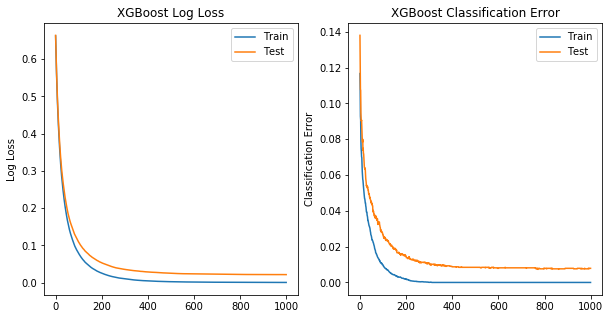

In [47]:
# make predictions for test data
y_pred = model2.predict(X_test)
#predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
plot_model_learning_curve(model2)

In [50]:
# save model to file
pickle.dump((model2, X_scaler), open("xgboost_allfeatures_large.pkl", "wb"))

In [51]:
# load model from file
loaded_model, X_scaler = pickle.load(open("xgboost_allfeatures_large.pkl", "rb"))

/home/xnguyen/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 99.21%


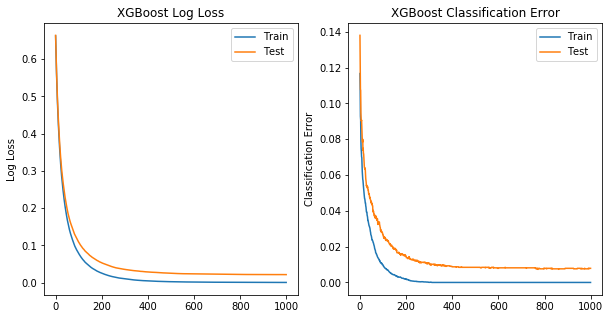

In [52]:
# make predictions for test data
y_pred = loaded_model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
plot_model_learning_curve(model2)